In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from rich.progress import track

sns.set(color_codes=True, style="white")

### Load Data

In [3]:
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/paper_figure_plots/Aug24_new_Figs/d2center_compare-FUS-aging3steps"
os.chdir(folder_save)

label1 = "- ring - fibril, 0 h"
label2 = "- ring - fibril, aged"
label3 = "+ ring - fibril, aged"
color1 = "#2b3744"
color2 = "#f7a863"
color3 = "#d25743"
palette = [color1, color2, color3]

postfix = "FUS-aging3steps.png"
fname1 = "distance2center-FUSonly_nothing-pooled-perTrack.p"
fname2_1 = "distance2center-FUSonly_8h_before_ring_complete-pooled-perTrack.p"
fname2_2 = "distance2center-FUSonly_24h_before_ring_complete-pooled-perTrack.p"
fname3_1 = "distance2center-FUSonly_8h_ring_completed-pooled-perTrack.p"
fname3_2 = "distance2center-FUSonly_24h_ring_completed-pooled-perTrack.p"

r_max = 1
ringwidth = 0.2
dr_slidingrings = 0.05
bin_starts = np.arange(0, r_max - ringwidth, dr_slidingrings)
bin_ends = bin_starts + ringwidth
ring_areas = np.pi * (bin_ends**2 - bin_starts**2)

def combine_dicts(dicts):
    """Combine several dictionaries with the same set of keys into one dictionary where each value is a list of all values for that key, keeping only specified keys."""
    combined = {}
    for d in dicts:
        for key, value in d.items():
            if key in combined:
                combined[key].extend(value)
            else:
                combined[key] = value.copy()
    return combined

dict1 = pickle.load(open(fname1, "rb"))
dict2_1 = pickle.load(open(fname2_1, "rb"))
dict2_2 = pickle.load(open(fname2_2, "rb"))
dict3_1 = pickle.load(open(fname3_1, "rb"))
dict3_2 = pickle.load(open(fname3_2, "rb"))

dict2 = combine_dicts([dict2_1, dict2_2])
dict3 = combine_dicts([dict3_1, dict3_2])

### Functions

In [4]:
def weighted_stats(lst_PCF_per_condensate_raw, lst_N_locations_raw):
    # cleaning out nan from list
    lst_N_locations = []
    lst_PCF_per_condensate = []
    for i, j in zip (lst_N_locations_raw, lst_PCF_per_condensate_raw):
        if np.isnan(j).any():
            continue
        else:
            lst_N_locations.append(i)
            lst_PCF_per_condensate.append(j)

    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_condensate[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array(
            [lst_PCF_per_condensate[j][i] for j in range(N_condensates)]
        )
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights)
        # calculate the variance
        variance = np.average((data_array - weighted_mean[i]) ** 2, weights=weights)
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std


def critical_system_PCF(r, A, characteristic_size):
    Gr = 1 + A * np.exp(-r / characteristic_size)
    return Gr


def calculate_hist(d2center_norm, r_max, bin_starts, bin_ends, ring_areas):
    # calculate histogram
    lst_hist = []
    for distance in d2center_norm[d2center_norm <= r_max]:
        lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
    hist = np.sum(lst_hist, axis=0)

    # determine normalization factors
    N_domains = d2center_norm[d2center_norm <= r_max].shape[0]
    rho_per_unit_circle = N_domains / (np.pi * 1**2)
    norm_factors = ring_areas * rho_per_unit_circle
    distribution = hist / norm_factors
    probability_norm = distribution / distribution.sum()

    return probability_norm


def bootstrap(d2center_norm, bs_size, bs_rounds):
    lst_probability_norm = []
    for i in track(range(bs_rounds)):
        idxs = np.random.choice(len(d2center_norm), bs_size)
        d2center_norm_bs = np.array([d2center_norm[idx] for idx in idxs], float)
        probability_norm = calculate_hist(
            d2center_norm_bs, r_max, bin_starts, bin_ends, ring_areas
        )

        lst_probability_norm.append(probability_norm)

    probability_norm_array = np.stack(lst_probability_norm)

    return probability_norm_array


def preprocessing(dict_input):
    lst_df_d2center = dict_input["lst_df_d2center"]
    lst_d2center_norm = [df["d2center_norm"].to_numpy(float) for df in lst_df_d2center]
    d2center_norm = np.hstack(lst_d2center_norm)
    probability_norm_array = bootstrap(d2center_norm, bs_size=5000, bs_rounds=1000)

    return probability_norm_array

### Domain distribution in condensate

In [5]:
probability_norm_array_1 = preprocessing(dict1)
probability_norm_array_2 = preprocessing(dict2)
probability_norm_array_3 = preprocessing(dict3)

Output()

Output()

Output()

In [6]:
def mean_err_for_plot(probability_norm_array):
    lst_mean = []
    lst_err = []
    for i in range(probability_norm_array.shape[1]):
        column = probability_norm_array[:, i]
        ci = (np.percentile(column, 5), np.percentile(column, 95))
        bs_mean = np.mean(ci)
        bs_err = (ci[1] - ci[0]) / 2
        lst_mean.append(bs_mean)
        lst_err.append(bs_err)

    return lst_mean, lst_err

lst_mean_1, lst_err_1 = mean_err_for_plot(probability_norm_array_1)
lst_mean_2, lst_err_2 = mean_err_for_plot(probability_norm_array_2)
lst_mean_3, lst_err_3 = mean_err_for_plot(probability_norm_array_3)


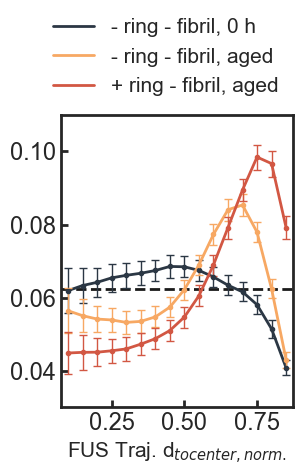

In [9]:
fontsize = 15

def preset_plot(lst_mean, lst_err, c, label):
    plt.errorbar(
        bar_x,
        lst_mean,
        yerr=lst_err,
        fmt=".",
        color=c,
        ecolor=c,
        elinewidth=1,
        capsize=3,
        label=None,
    )
    line, = plt.plot(
        bar_x,
        lst_mean,
        color=c,
        lw=2,
        label=label,
    )
    return line

plt.figure(figsize=(3, 3.8))
plt.axhline(1 / len(bin_starts), c="k", ls="--", lw=2)
bar_x = (bin_starts + bin_ends) / 2

# Collect line objects for legend
lines = []
lines.append(preset_plot(lst_mean_1, lst_err_1, color1, label1))
lines.append(preset_plot(lst_mean_2, lst_err_2, color2, label2))
lines.append(preset_plot(lst_mean_3, lst_err_3, color3, label3))

# Configure legend using only line objects
plt.legend(
    handles=lines,
    loc="lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=1,
    title=None,
    frameon=False,
    fontsize=fontsize,
)

plt.xlim(bar_x[0] - dr_slidingrings / 2, bar_x[-1] + dr_slidingrings / 2)
# plt.xlim(0, 1)
plt.ylim(0.03, 0.11)
plt.ylabel("Probability$_{norm.}$", fontsize=fontsize)
plt.xlabel("FUS Traj. d$_{to center, norm.}$", fontsize=fontsize)
plt.ylabel("")
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=17,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "d2center_distribution" + postfix,
    format="png",
    bbox_inches="tight",
    dpi=300,
)
# baseline = 1 / len(bin_starts)
# print(
#     lst_mean[0] / baseline,
#     lst_err[0] / baseline,
#     bar_x[-5],
#     lst_mean[-5] / baseline,
#     lst_err[-5] / baseline,
# )